# Sentiment Analysis of Valheim (Video Game) based on Twitter Dataset using Keras BiLSTM

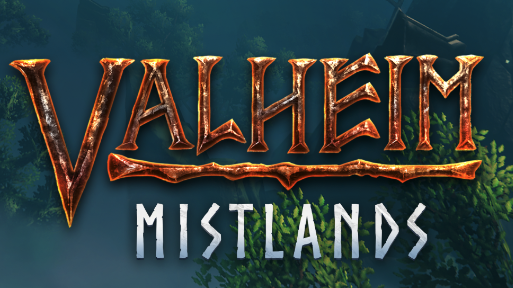

Valheim is a video game with a nord-inspired theme. The game's main aspects are exploration and adventure. With the last announcement of the latest major update (Mistland update), the game has gained some attention among the gamer community in twitter. This project aims to analyze the sentiment of Valheim players on Twitter and uses it to train a BiLSTM model. The model would be evaluated and its result should tell whether the model is usable for prediction or not.

## Preprocessing

In [1]:
#Importing essential libraries
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from guess_language import guess_language as guess
from collections import Counter
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import preprocessor as p
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Bidirectional, Activation
from tensorflow.keras.layers import Embedding
import keras.backend as K
import joblib

In [ ]:
##Scrape data from twitter

#attrs = []
#limit = 0

#for i,tweet in enumerate(sntwitter.TwitterSearchScraper('Valheim since:2022-11-01 until:2022-12-16').get_items()):
#    if limit>4999:
#        break
#    if(str(guess(tweet.content)) == "en"):
#        attrs.append([tweet.user.username, tweet.date, tweet.likeCount, tweet.sourceLabel, tweet.content])
#        limit += 1
    
## Creating a dataframe to load the list
#df = pd.DataFrame(attrs, columns=["User", "Date Created", "Number of Likes", "Source of Tweet", "Tweet"])
#df['Date Created'] = pd.to_datetime(df['Date Created']).dt.date

#pd.to_csv("scrapped_tweet.csv")

In [2]:
#Load twitter data and show first lines

df = pd.read_csv('scrapped_tweet.csv')
df = df.iloc[:,1:]
df.head()

,User,Date Created,Number of Likes,Source of Tweet,Tweet
0,ElPibeCombo,2022-12-15,0,Twitter Web App,"@BS_artsss Oh, this is so good, i love it! can..."
1,MrsTadertaut,2022-12-15,5,Twitter Web App,Hello lovelies!\n\nTonight we are jumping back...
2,Meganoip,2022-12-15,0,Twitter Web App,Storyline: Noi found Block fighting with giant...
3,TaesTeahouse,2022-12-15,2,Twitter Web App,Ayo I'm totally not biased or anything but yal...
4,John90192410,2022-12-15,1,Twitter for Android,The Queen Wants it all... \nDid Mistlands solo...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User             5000 non-null   object
 1   Date Created     5000 non-null   object
 2   Number of Likes  5000 non-null   int64 
 3   Source of Tweet  5000 non-null   object
 4   Tweet            5000 non-null   object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB


In [4]:
#Create new list with tweet as its values

tweet = (df["Tweet"].values.tolist())

In [5]:
#Initialize lemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()

In [6]:
#Create new variable to be filled with English stop-words
stop_words = nltk.corpus.stopwords.words('english')

In [8]:
#Fix contractions
contractions.add('cant', 'can not')

In [9]:
#Cleaning the tweets

#Create a new list to store the cleaned tweets
clean_tweet = []
for i in range(0,len(tweet)):
    #Undercase all letters
    temp = p.clean(tweet[i]).casefold()
    #Remove all punctuations
    temp = temp.translate(str.maketrans('', '', string.punctuation))
    #Create new list to store filtered tokenized words
    filtered = []
    #Create new variable for tokenized sentence
    words_temp = word_tokenize(temp)
    #Create new variable to store string that has its contractions removed
    str_temp_fixed = ""
    #Clean the words from contractions
    for j in words_temp:
        j = contractions.fix(j)
        str_temp_fixed += " " + j
    #Create new variable for the cleaned tokenized sentence
    words_temp_fixed = word_tokenize(str_temp_fixed)
    for c in words_temp_fixed:
        #Check if a word is a stop word
        if c not in stop_words:
            #Lemmatize the word, then stores it into the "filtered" list
            c = wordnet_lemmatizer.lemmatize(c)
            filtered.append(c)
    #Create a new variable to store the filtered words that are re-combined back into a sentence
    cleaned = " ".join(filtered)
    #Insert the "cleaned" variable to "clean_tweet" list
    clean_tweet.append(cleaned)
    
#Create a new dataframe filled with the cleaned tweets
clean_tweet = pd.DataFrame(clean_tweet, columns=["Tweet"])
clean_tweet.head()

,Tweet
0,oh good love wait get home play valheim
1,hello loveliestonight jumping back made copper...
2,storyline noi found block fighting giant valhe...
3,ayo totally biased anything go watch lil si pl...
4,queen want mistlands solo cheating died time b...


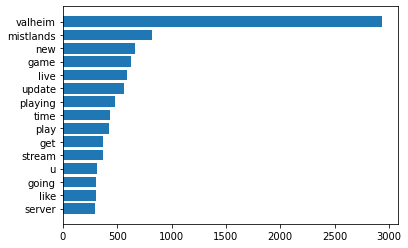

In [10]:
#Manual stop words removal for confirmation

def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

#Take 20 top words
a =  ' '.join(map(str, clean_tweet["Tweet"]))
counted = {k: v for k, v in sorted(word_count(a).items(), key=lambda item: item[1], reverse=True)}
counted = dict(Counter(counted).most_common(15))

plt.barh(range(len(counted)), list(counted.values()), align='center')
plt.yticks(range(len(counted)), list(counted.keys()))
plt.gca().invert_yaxis()
plt.show()

The graph shows some words that are stopwords but haven't removed already. The next lines will remove the words from the tweet.

In [11]:
manual_stop = ['valheim', 'mistlands', 'new', 'game', 'live', 
               'update', 'playing', 'time', 'play', 'get', 'stream', 
               'u', 'going', 'server', 'am', 'pm', 'est', 'tonight', 'today', 'tomorrow', 'yesterday']

#Create a new list to store the cleaned tweets
manual_clean_tweet = []
for i in range(0,len(tweet)):
    temp = clean_tweet.iloc[i,0]
    #Create new list to store filtered tokenized words
    filtered = []
    #Create new variable for tokenized sentence
    words_temp = word_tokenize(temp)
    for c in words_temp:
        #Check if a word is a stop word
        if c not in manual_stop:
            #Stores it into the "filtered" list
            filtered.append(c)
    #Create a new variable to store the filtered words that are re-combined back into a sentence
    cleaned = " ".join(filtered)
    #Insert the "cleaned" variable to "manual_clean_tweet" list
    manual_clean_tweet.append(cleaned)
    
#Create a new dataframe filled with the cleaned tweets
clean_tweet["Tweet"] = manual_clean_tweet
clean_tweet.head()

,Tweet
0,oh good love wait home
1,hello loveliestonight jumping back made copper...
2,storyline noi found block fighting giant drago...
3,ayo totally biased anything go watch lil si
4,queen want solo cheating died biome felt impos...


In [12]:
#Add new columns to the dataframe for the result of the analyzer

sentiments = SentimentIntensityAnalyzer()
clean_tweet["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in clean_tweet["Tweet"]]
clean_tweet["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in clean_tweet["Tweet"]]
clean_tweet['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in clean_tweet["Tweet"]]

clean_tweet.head()

,Tweet,Positive,Neutral,Compound
0,oh good love wait home,0.703,0.297,0.7964
1,hello loveliestonight jumping back made copper...,0.000,1.000,0.0000
2,storyline noi found block fighting giant drago...,0.000,0.772,-0.7717
3,ayo totally biased anything go watch lil si,0.000,0.745,-0.3384
4,queen want solo cheating died biome felt impos...,0.188,0.348,-0.8360


Originally, the *SentimentIntensityAnalyzer* has 4 columns Positive, Neutral, Negative, Compound. For the sake of simplicity, the Neutral result are dismissed from the column. Compound column tells which "way" does the sentiment probably headed to. A positive compound means the sentence is more likely be a positive one, and vice versa for the negative compound. True 0 compound means the sentence is completely neutral, but in this research it's recognized as a negative sentence.

In [13]:
#Create a new column in the dataframe to store the sentiment of each tweets using Compound value

score = clean_tweet["Compound"].values
sentiment = []
for i in score:
    if i > 0 :
        sentiment.append(1)
    else:
        sentiment.append(0)
clean_tweet["Sentiment"] = sentiment

clean_tweet.head()

,Tweet,Positive,Neutral,Compound,Sentiment
0,oh good love wait home,0.703,0.297,0.7964,1
1,hello loveliestonight jumping back made copper...,0.000,1.000,0.0000,0
2,storyline noi found block fighting giant drago...,0.000,0.772,-0.7717,0
3,ayo totally biased anything go watch lil si,0.000,0.745,-0.3384,0
4,queen want solo cheating died biome felt impos...,0.188,0.348,-0.8360,0


In [14]:
#Create a tokenizer, and fit the Tweet to the tokenizer.
t = Tokenizer()
t.fit_on_texts(clean_tweet["Tweet"])

In [15]:
#Encode the tweets then pad it
encoded_tweets = t.texts_to_sequences(tweet)
padded_tweets = pad_sequences(encoded_tweets, padding='post', maxlen=100)

## Manual Analysis

[Text(0, 0, '2676'), Text(0, 0, '2324')]

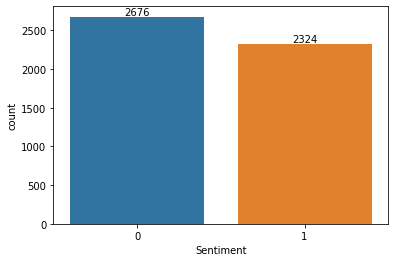

In [16]:
ax = sns.countplot(x=clean_tweet["Sentiment"])
ax.bar_label(ax.containers[0])

More than half of the sentiments against Valheim are negative (2676), and the rest are positive (2324).

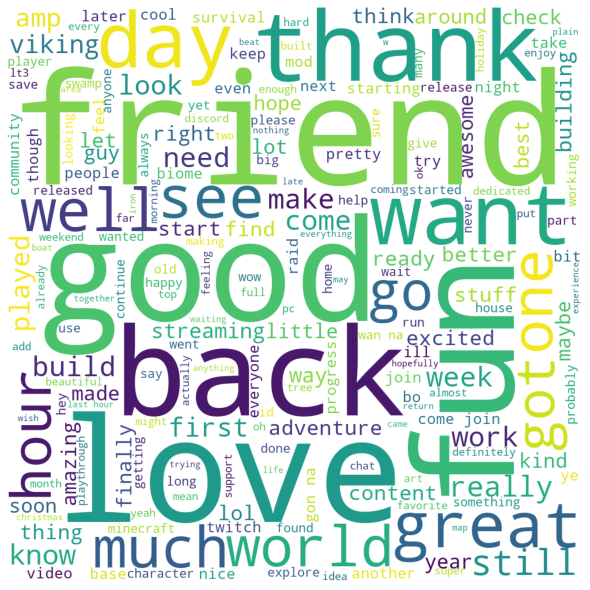

In [17]:
#Initialize and show the WordCloud for positive sentiments
WC_pos = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                min_font_size = 10).generate(' '.join(map(str, (clean_tweet.loc[clean_tweet['Sentiment'] == 1, 'Tweet']))))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(WC_pos)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

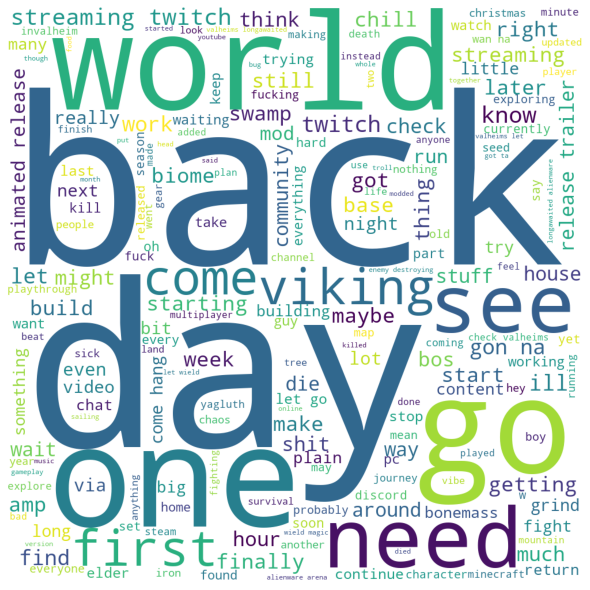

In [18]:
#Initialize and show the WordCloud for negative sentiments
WC_neg = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                min_font_size = 10).generate(' '.join(map(str, (clean_tweet.loc[clean_tweet['Sentiment'] == 0, 'Tweet']))))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(WC_neg)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

-- Positive Wordcloud Analysis
The most obvious positive words that shows up are friend, fun, good, and love. As an online and *mostly* cooperative game, the game experience would most likely be better when there are friends that are playing together.

--Negative Wordcloud Analysis
The most obvious negative words that shows up are back, day, one. This could be correlated to the new major update that contains a new update called "Mistland biome". Its difficulties might be the one making players frustated by having their items lost in the new biome, and they are unable to retrieve it back.

## Modelling

In [19]:
#Creating feature and target variables
X = padded_tweets
y = clean_tweet["Sentiment"]

In [20]:
#Splitting 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)

In [21]:
#Creating the BiLSTM model
model = Sequential()
model.add(Embedding((len(t.word_index) + 1), 10, input_length = 100))
model.add(Bidirectional(LSTM(5, return_sequences=True)))
model.add(Bidirectional(LSTM(5)))
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=['binary_crossentropy'] , optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           80760     
                                                                 
 bidirectional (Bidirectiona  (None, 100, 10)          640       
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10)               640       
 nal)                                                            
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 82,051
Trainable params: 82,051
Non-traina

In [22]:
#Compiling the model with 10 epochs
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=35,epochs=10)

Epoch 1/10
100/100 [==============================] - 10s 53ms/step - loss: 0.6840 - accuracy: 0.5537 - val_loss: 0.6637 - val_accuracy: 0.6387
Epoch 2/10
100/100 [==============================] - 4s 42ms/step - loss: 0.6103 - accuracy: 0.7449 - val_loss: 0.5744 - val_accuracy: 0.7660
Epoch 3/10
100/100 [==============================] - 4s 44ms/step - loss: 0.4934 - accuracy: 0.8554 - val_loss: 0.5405 - val_accuracy: 0.7780
Epoch 4/10
100/100 [==============================] - 4s 44ms/step - loss: 0.3825 - accuracy: 0.9214 - val_loss: 0.4884 - val_accuracy: 0.7920
Epoch 5/10
100/100 [==============================] - 5s 49ms/step - loss: 0.2734 - accuracy: 0.9486 - val_loss: 0.4822 - val_accuracy: 0.8073
Epoch 6/10
100/100 [==============================] - 5s 49ms/step - loss: 0.2554 - accuracy: 0.9394 - val_loss: 0.5260 - val_accuracy: 0.7407
Epoch 7/10
100/100 [==============================] - 5s 50ms/step - loss: 0.2394 - accuracy: 0.9591 - val_loss: 0.4695 - val_accuracy: 0.816

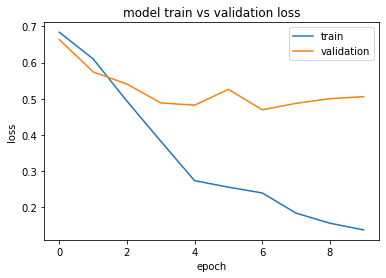

In [23]:
#Creating the model's train loss against validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

The model starts to overfit after the 4 epoch, the validation loss rises starting from the 5th epoch. The next lines will create the same model and trains it only until the 4 epoch.

In [27]:
#Creating the BiLSTM model
model = Sequential()
model.add(Embedding((len(t.word_index) + 1), 10, input_length = 100))
model.add(Bidirectional(LSTM(5, return_sequences=True)))
model.add(Bidirectional(LSTM(5)))
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=['binary_crossentropy'] , optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 10)           80760     
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 10)          640       
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 10)               640       
 nal)                                                            
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 82,051
Trainable params: 82,051
Non-trai

In [28]:
#Compiling the model with 4 epochs
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=35,epochs=4)

Epoch 1/4
100/100 [==============================] - 10s 56ms/step - loss: 0.6832 - accuracy: 0.5466 - val_loss: 0.6694 - val_accuracy: 0.5900
Epoch 2/4
100/100 [==============================] - 4s 44ms/step - loss: 0.6279 - accuracy: 0.7283 - val_loss: 0.5857 - val_accuracy: 0.7687
Epoch 3/4
100/100 [==============================] - 5s 48ms/step - loss: 0.4592 - accuracy: 0.8877 - val_loss: 0.5090 - val_accuracy: 0.7920
Epoch 4/4
100/100 [==============================] - 5s 51ms/step - loss: 0.3395 - accuracy: 0.9394 - val_loss: 0.4716 - val_accuracy: 0.8120


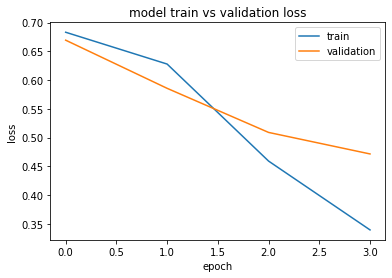

In [29]:
#Creating the model's train loss against validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [33]:
#Saves the model
joblib.dump(model, "valheim_bilstm_mistlands_twitter.sav")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\bidirectional
......vars
...layers\bidirectional\backward_layer
......vars
...layers\bidirectional\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\forward_layer
......vars
...layers\bidirectional\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\layer
......vars
...layers\bidirectional\layer\cell
......vars
...layers\bidirectional_1
......vars
...layers\bidirectional_1\backward_layer
......vars
...layers\bidirectional_1\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional_1\forward_layer
......vars
...layers\bidirectional_1\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional_1\layer
......vars
...layers\bidirectional_1\layer\cell
......vars
...layers\dense
......vars
.........0
.........1
...layers\embedding
......vars
.........0
...me

['valheim_bilstm_mistlands_twitter.sav']